In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import make_uniform, make_joint, plot_contour, transform

In [3]:
link = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv'
data = pd.read_csv(link, parse_dates=['Date'])
data.rename(columns={'Damage Incident': 'Damage'}, inplace=True)
data.drop(labels=[3, 24], inplace=True)
data['Damage'] = data['Damage'].astype(int)
data.head(), data.shape

(        Date  Temperature  Damage
 0 1981-04-12           66       0
 1 1981-11-12           70       1
 2 1982-03-22           69       0
 4 1982-01-11           68       0
 5 1983-04-04           67       0,
 (23, 3))

In [4]:
# 데이터 중심화로 offset을 표현 → 추정치의 정확도를 높이고, 파라미터간 상관관계를 줄여줌
offset = round(data['Temperature'].mean(), 1)
data['x'] = data['Temperature'] - offset
data['y'] = data['Damage']

In [5]:
formula = 'y ~ x'
results = smfa.logit(formula, data=data).fit(disp=False)
results.params

Intercept   -1.115625
x           -0.232163
dtype: float64

In [6]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 Sep 2023   Pseudo R-squ.:                  0.2813
Time:                        18:07:30   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1156      0.581     -1.921      0.055      -2.254       0.023
x             -0.2322      0.108     -2.145      0.032      -0.444      -0.020
==============================================================================
"""

In [7]:
inter = results.params['Intercept']
slope = results.params['x']
xs = np.arange(53, 83) - offset
log_odds = inter + slope * xs
#odds = np.exp(log_odds)
#ps = odds / (odds + 1)
ps = expit(log_odds)

In [8]:
log_odds, ps

(array([ 2.7382762 ,  2.50611346,  2.27395072,  2.04178797,  1.80962523,
         1.57746248,  1.34529974,  1.11313699,  0.88097425,  0.64881151,
         0.41664876,  0.18448602, -0.04767673, -0.27983947, -0.51200221,
        -0.74416496, -0.9763277 , -1.20849045, -1.44065319, -1.67281594,
        -1.90497868, -2.13714142, -2.36930417, -2.60146691, -2.83362966,
        -3.0657924 , -3.29795515, -3.53011789, -3.76228063, -3.99444338]),
 array([0.93924781, 0.92456929, 0.90669655, 0.88511521, 0.85931657,
        0.82884484, 0.79336013, 0.75271348, 0.70702407, 0.65674259,
        0.60268105, 0.54599114, 0.48808308, 0.43049313, 0.37472428,
        0.32209405, 0.27362105, 0.22996826, 0.19144422, 0.1580491 ,
        0.12954602, 0.10553894, 0.08554356, 0.06904407, 0.05553372,
        0.04454055, 0.03564141, 0.02846733, 0.02270329, 0.01808462]))

In [9]:
qs_inter = np.linspace(-5, 1, 101)
qs_slope = np.linspace(-0.8, 0.1, 101)
prior_inter = make_uniform(qs_inter, name='Intercept')
prior_slope = make_uniform(qs_slope, name='Slope')
joint_pmf = Pmf(make_joint(prior_inter, prior_slope).stack())
joint_pmf.head(5)

-0.8  -5.00    0.000098
      -4.94    0.000098
      -4.88    0.000098
      -4.82    0.000098
      -4.76    0.000098
Name: , dtype: float64

In [10]:
grouped = data.groupby('x')['y'].agg(['count', 'sum'])
grouped.head()

,count,sum
x,,
-16.6,1,1
-12.6,1,1
-11.6,1,1
-6.6,1,1
-3.6,1,0


In [11]:
ns = grouped['count']
ks = grouped['sum']
xs = grouped.index
ps = expit(inter + slope * xs)

In [12]:
likes = ss.binom(ns, ps).pmf(ks)
likes.prod()

0.0004653644508250071

In [13]:
likelihood = joint_pmf.copy()
for slope, inter in joint_pmf.copy().index:
    ps = expit(inter + slope * xs)
    likes = ss.binom(ns, ps).pmf(ks)
    likelihood[slope, inter] = likes.prod()

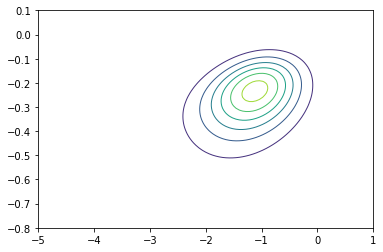

In [14]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()
plot_contour(posterior_pmf.unstack())

<AxesSubplot:>

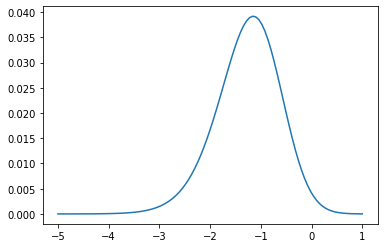

In [15]:
marginal_inter = posterior_pmf.marginal(1)
marginal_inter.plot()

<AxesSubplot:>

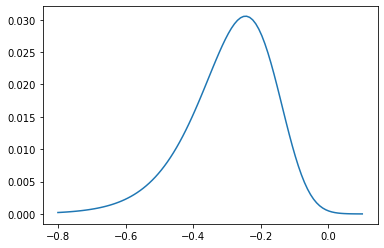

In [16]:
marginal_slope = posterior_pmf.marginal(0)
marginal_slope.plot()

In [18]:
# x가 0일 때의 로그오즈를 확률 값으로 변환
marginal_probs = marginal_inter.transform(expit)
marginal_probs

,probs
0.006693,0.000002
0.007104,0.000002
0.007540,0.000003
0.008002,0.000003
0.008493,0.000004
...,...
0.681354,0.000059
0.694236,0.000039
0.706822,0.000025
0.719100,0.000016


In [19]:
# Log-Likelihood를 일반 Likelihood(가능도비, Bayes Factor)로 변환
marginal_lr = marginal_slope.transform(np.exp)
marginal_lr

,probs
0.449329,0.000218
0.453391,0.000244
0.457490,0.000272
0.461626,0.000304
0.465799,0.000339
...,...
1.066092,0.000022
1.075731,0.000013
1.085456,0.000008
1.095269,0.000005


In [25]:
sample = posterior_pmf.choice(101)
temps = np.arange(31, 83)
xs = temps - offset

In [27]:
# np.empty() 선언한 matrix에 무작위 값을 입력
pred = np.empty((len(sample), len(xs)))
for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)

In [29]:
pred[0]

array([0.99930548, 0.99914675, 0.99895177, 0.99871229, 0.99841819,
       0.99805704, 0.99761365, 0.99706936, 0.99640138, 0.99558182,
       0.99457663, 0.99334428, 0.99183419, 0.98998494, 0.98772209,
       0.98495574, 0.98157771, 0.97745855, 0.97244421, 0.96635283,
       0.95897172, 0.95005512, 0.9393233 , 0.92646399, 0.91113721,
       0.89298493, 0.87164697, 0.8467844 , 0.81811079, 0.78543079,
       0.74868289, 0.70798133, 0.66364942, 0.61623547, 0.56650361,
       0.51539513, 0.4639626 , 0.41328543, 0.36438084, 0.31812543,
       0.27519953, 0.23606058, 0.20094477, 0.16989099, 0.14277873,
       0.11937101, 0.09935606, 0.08238307, 0.06809037, 0.05612566,
       0.04615922, 0.03789152])

In [31]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
low, high

(array([9.48962082e-01, 9.44001349e-01, 9.38589651e-01, 9.32692256e-01,
        9.26273005e-01, 9.19294515e-01, 9.12248222e-01, 9.04857353e-01,
        8.96914334e-01, 8.88389982e-01, 8.79255629e-01, 8.69483534e-01,
        8.58756493e-01, 8.42904531e-01, 8.25634714e-01, 8.07648110e-01,
        7.86675272e-01, 7.64947804e-01, 7.41733880e-01, 7.17075285e-01,
        6.91043012e-01, 6.63738697e-01, 6.35294849e-01, 6.05873668e-01,
        5.76397009e-01, 5.56754353e-01, 5.36932610e-01, 5.16993452e-01,
        4.97000036e-01, 4.64460036e-01, 4.13770471e-01, 3.64844179e-01,
        3.32921723e-01, 3.04237441e-01, 2.63161660e-01, 2.22077584e-01,
        1.81383819e-01, 1.47493088e-01, 1.09544721e-01, 7.46887976e-02,
        5.24310864e-02, 3.85383807e-02, 2.70722660e-02, 1.82065416e-02,
        9.78956945e-03, 5.24302416e-03, 2.80204442e-03, 1.67611356e-03,
        1.02340096e-03, 6.24708820e-04, 3.81278167e-04, 2.32683194e-04]),
 array([0.99999999, 0.99999998, 0.99999996, 0.99999993, 0.9999

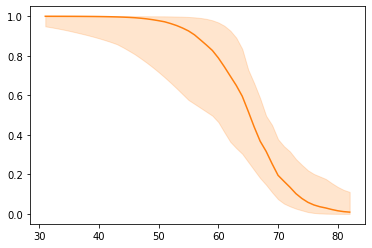

In [32]:
plt.fill_between(temps, low, high, color='C1', alpha=0.2)
plt.plot(temps, median, color='C1', label='logistic model')